In [276]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nifty50-stocks-dataset/National_Stock_Exchange_of_India_Ltd.csv


In [277]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/kaggle/input/nifty50-stocks-dataset/National_Stock_Exchange_of_India_Ltd.csv')
print(data.head())

       Symbol       Open       High        Low        LTP    Chng  % Chng  \
0  ADANIPORTS        750        766     713.25        715  -47.45   -6.22   
1  ASIANPAINT   3,101.00   3,167.35   3,091.00   3,138.00   -6.25   -0.20   
2    AXISBANK        669      674.9     660.45        661  -18.90   -2.78   
3  BAJAJ-AUTO   3,370.00   3,383.50   3,320.00   3,335.00  -56.70   -1.67   
4  BAJAJFINSV  17,200.00  17,237.20  16,610.00  16,684.00 -684.85   -3.94   

   Volume (lacs) Turnover (crs.)      52w H     52w L  365 d % chng  \
0          72.20          532.63        901     384.4         79.22   
1          10.29          322.53   3,505.00  2,117.15         45.66   
2         102.53             684      866.9     568.4         10.19   
3           3.42          114.59   4,361.40  3,041.00          9.30   
4           3.42          576.79  19,325.00  8,273.70         91.38   

   30 d % chng  
0        -4.65  
1         5.66  
2       -21.49  
3       -12.05  
4        -9.10  


In [278]:
# Checking for missing values:
print(data.isnull().sum())

Symbol             0
Open               0
High               0
Low                0
LTP                0
Chng               0
% Chng             0
Volume (lacs)      0
Turnover (crs.)    0
52w H              0
52w L              0
365 d % chng       0
30 d % chng        0
dtype: int64


Visualizing the evolution of the Last Traded Price (LTP) over time using a simple line plot:

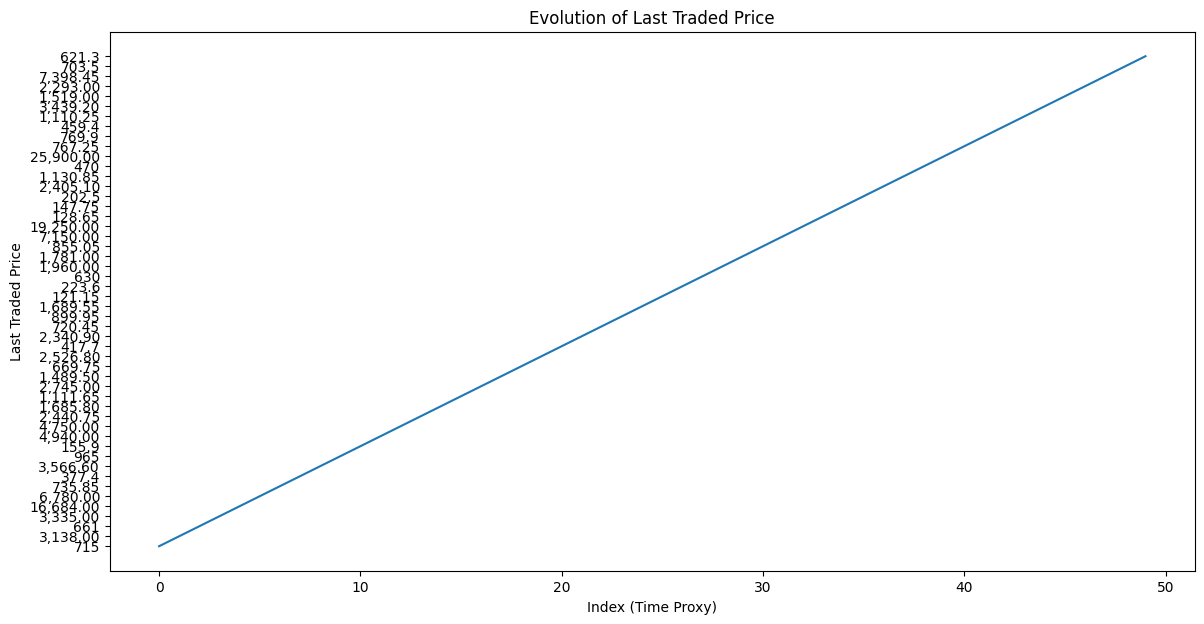

In [279]:
plt.figure(figsize=(14, 7))
plt.plot(data['LTP'])
plt.title('Evolution of Last Traded Price')
plt.xlabel('Index (Time Proxy)')
plt.ylabel('Last Traded Price')
plt.show()

The chart provides insights into the price fluctuations and potential patterns over the given time frame.

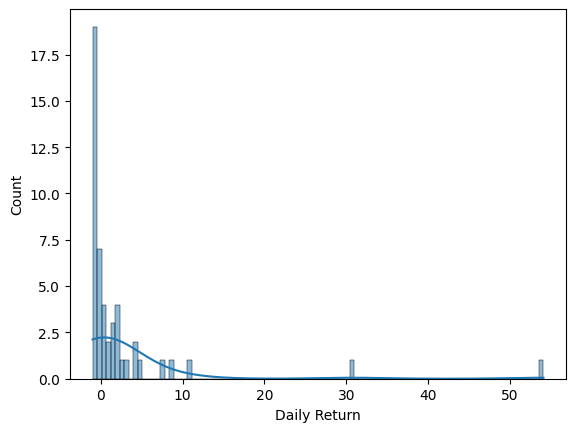

In [280]:
# Convert 'LTP' column to numeric
data['LTP'] = pd.to_numeric(data['LTP'].str.replace(',', ''), errors='coerce')

# Computing the daily returns
data['Daily Return'] = data['LTP'].pct_change()
sns.histplot(data['Daily Return'].dropna(), bins=100, kde=True)
plt.show()

**Financial Forecasting & Stock Price Forecasts**

In [281]:
data['Prev LTP'] = data['LTP'].shift(1)
data.dropna(inplace=True)  # Remove NaN values introduced by the shift

In [282]:
from sklearn.model_selection import train_test_split

X = data[['Prev LTP']]
y = data['LTP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [283]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)
print(predictions)

[3024.59024323 3064.45576994 2810.17058304 2981.4074549  3065.7316398
 3102.90486487 3120.48159397 3124.9125386  2820.9160022  3020.86859574]


In [284]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))

Mean Absolute Error: 3364.225728188674
Mean Squared Error: 30732256.01394219
Root Mean Squared Error: 5543.6681009907325


The RMSE and MAE are in the same unit as your target variable, which provides context. In this case, an RMSE of 5543.67 is quite substantial. Since we are predicting stock prices, this suggests that on average, the model's predictions can be off by more than 5k units, which is considerable.
As RMSE is significantly larger than MAE, it indicates that your model is occasionally making large errors, i.e., there might be significant outliers or instances where the model's predictions are way off.

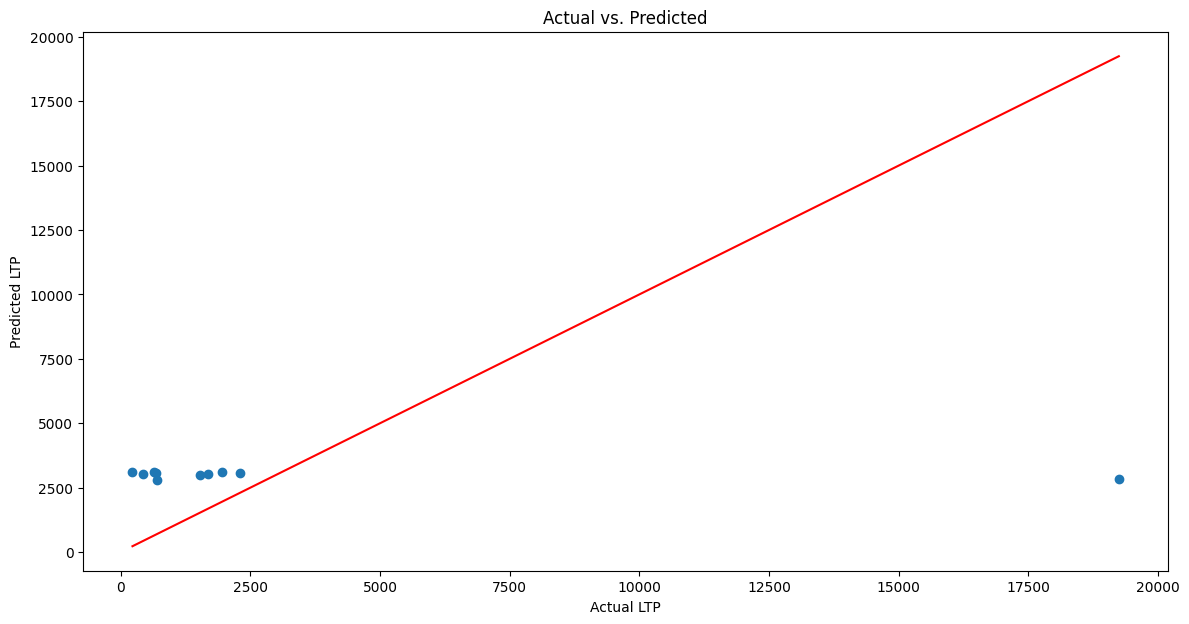

In [285]:
plt.figure(figsize=(14, 7))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect prediction
plt.title('Actual vs. Predicted')
plt.xlabel('Actual LTP')
plt.ylabel('Predicted LTP')
plt.show()

As we can see the scatter points lie above the line, the model tends to over-predict.

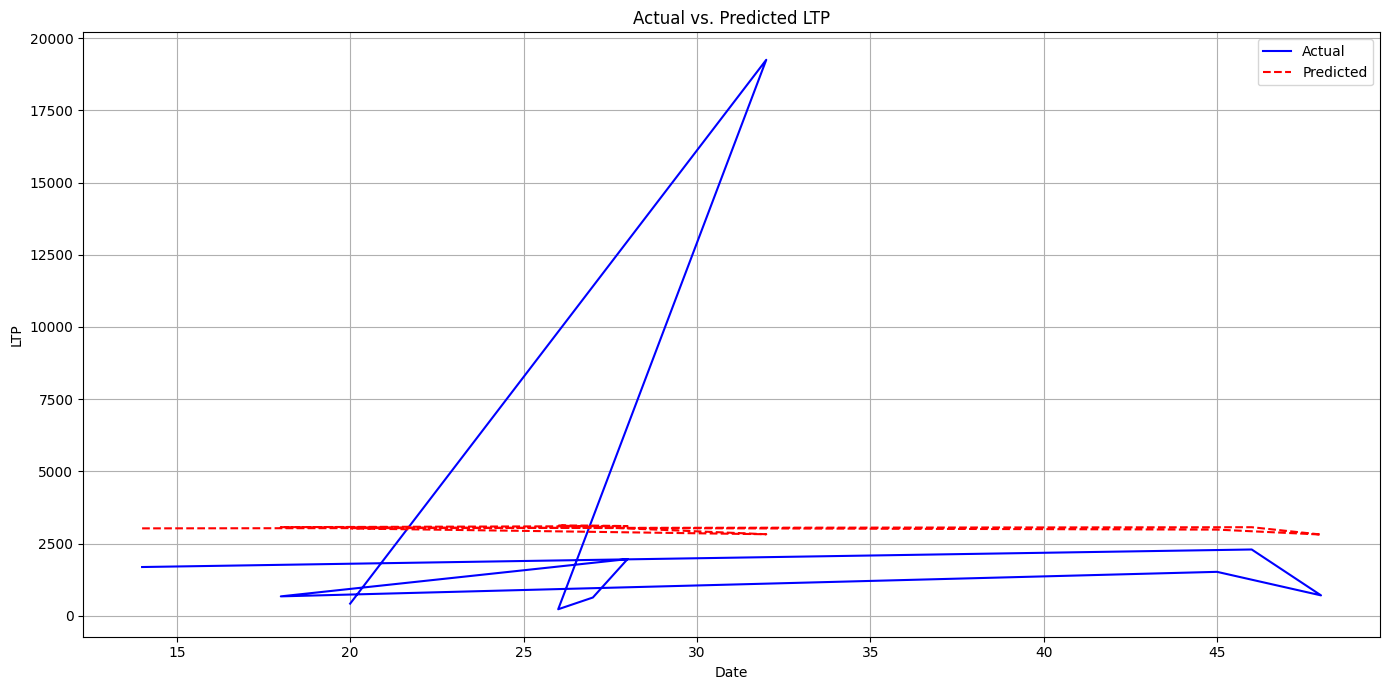

In [286]:
# Extract the corresponding dates for X_test
test_dates = X_test.index

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test, label='Actual', color='blue')
plt.plot(test_dates, predictions, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs. Predicted LTP')
plt.xlabel('Date')
plt.ylabel('LTP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [287]:
# Moving Averages
data['MA5'] = data['LTP'].rolling(window=5).mean()  # 5-day moving average
data['MA10'] = data['LTP'].rolling(window=10).mean()  # 10-day moving average

# Daily Return
data['Daily Return'] = data['LTP'].pct_change()

# Momentum (Rate of Change)
data['Momentum'] = data['LTP'] - data['LTP'].shift(4)

# Rolling Volatility (we'll use standard deviation of daily return)
data['Volatility'] = data['Daily Return'].rolling(window=5).std()

# Drop NaN values
data = data.dropna()

In [288]:
# Using the features to predict the next day's closing price (shift LTP by -1)
X = data[['MA5', 'MA10', 'Momentum', 'Volatility', 'Daily Return']]
y = data['LTP'].shift(-1).dropna()

# Removing the last row of X as we don't have a y value for it
X = X[:-1]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [289]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6420501.678778094


Lets try to showcase a more comprehensive approach towards predicting stock prices, incorporating both technical indicators and price-derived metrics.

* MA5 represents the 5-day moving average of the Last Traded Price (LTP). It smoothens the data to show general price trends.
* MA10 is the 10-day moving average, providing an even smoother representation of price trends.
* Daily Return is the percentage change in the LTP from the previous day to the current day.
* Momentum gives an indication of the strength of the stock's movement. A positive momentum suggests upward movement, while negative momentum indicates a downward trend.
* Volatility is calculated as the standard deviation of the daily return over a 5-day window.

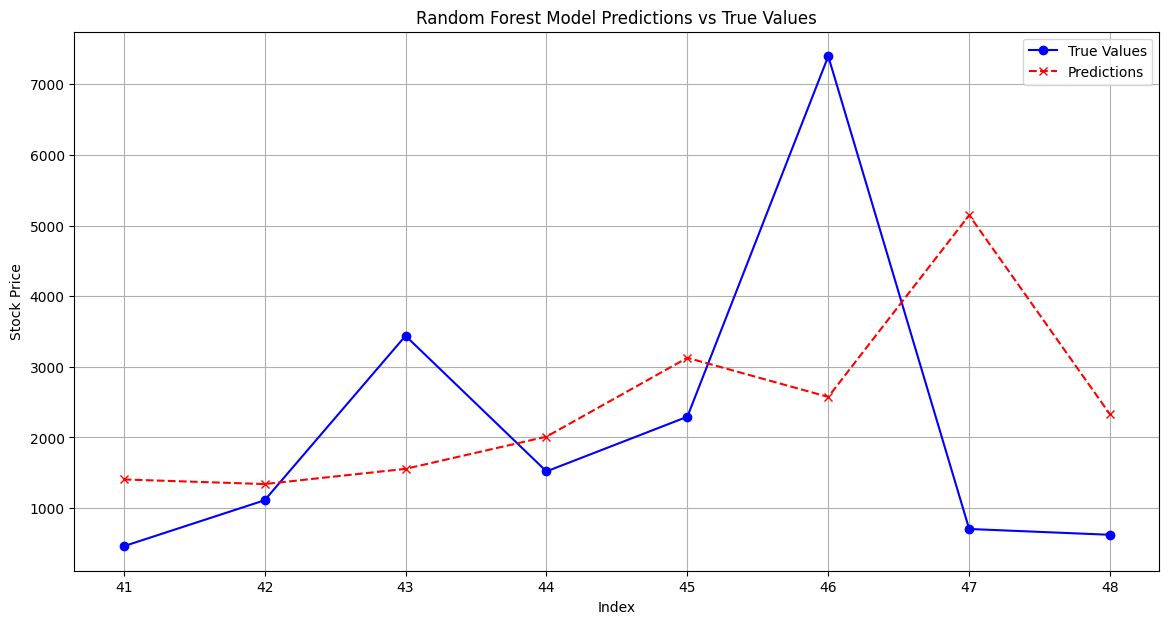

In [290]:
# Plotting the real vs predicted values
plt.figure(figsize=(14,7))
plt.plot(y_test.index, y_test.values, color='blue', label='True Values', marker='o')
plt.plot(y_test.index, predictions, color='red', linestyle='dashed', label='Predictions', marker='x')
plt.title('Random Forest Model Predictions vs True Values')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

Since the model struggles in areas of the plot where the blue line has sharp rises or falls, it might have difficulty with high volatility.


**Price Movement Classification**

This methodology provides a more holistic approach to stock price prediction by considering multiple price-derived indicators. However, stock price prediction is inherently challenging due to the multitude of factors influencing stock prices, many of which cannot be easily quantified.

In [291]:
# 1. Dropping non-numeric data:
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
data = data[numeric_columns]

# 2. Creating the target variable and direction column:

# Creating a new column 'Target' which is shifted by -1
data['Target'] = data['LTP'].shift(-1)

# Creating a new binary column 'Direction'. 
# If the next day's price (Target) is greater than today's price, then 1 else 0
data['Direction'] = (data['Target'] > data['LTP']).astype(int)

# Drop the 'Target' column
data.drop(columns='Target', inplace=True)

# 3. Train-test split and evaluate the model:

X = data.drop(columns='Direction').values[:-1] # Removing the last row as it doesn't have a label
y = data['Direction'].values[:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classifier model (Random Forest for illustration)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

data.head(15)

Accuracy: 62.50%


,LTP,Chng,% Chng,Volume (lacs),365 d % chng,30 d % chng,Daily Return,Prev LTP,MA5,MA10,Momentum,Volatility,Direction
10,155.90,-2.65,-1.67,118.30,25.78,-10.94,-0.838446,965.00,1160.15,3639.875,-579.95,4.111521,1
11,4940.00,140.20,2.92,15.71,42.39,-1.57,30.686979,155.90,2000.98,3820.075,4562.60,13.597352,0
12,4750.00,158.40,3.45,10.72,-1.17,1.80,-0.038462,4940.00,2875.50,4228.975,1183.40,13.533485,0
13,2440.75,-79.65,-3.16,5.55,-5.95,-5.77,-0.486158,4750.00,2650.33,4139.550,1475.75,13.960970,0
14,1685.80,-80.95,-4.58,7.48,99.95,-3.08,-0.309311,2440.75,2794.49,2639.730,1529.90,13.913642,0
15,1111.65,-13.15,-1.17,22.07,34.79,-4.73,-0.340580,1685.80,2985.64,2072.895,-3828.35,13.855892,1
16,2745.00,-122.75,-4.28,33.53,25.27,-5.72,1.469302,1111.65,2546.64,2273.810,-2005.00,0.804824,0
17,1489.50,-36.45,-2.39,93.12,6.18,-9.88,-0.457377,2745.00,1894.54,2385.020,-951.25,0.838597,0
18,669.75,-19.05,-2.77,22.37,0.70,-2.94,-0.550352,1489.50,1540.34,2095.335,-1016.05,0.847866,1
19,2526.80,-67.90,-2.62,6.85,-16.02,-6.43,2.772751,669.75,1708.54,2251.515,1415.15,1.483267,0


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


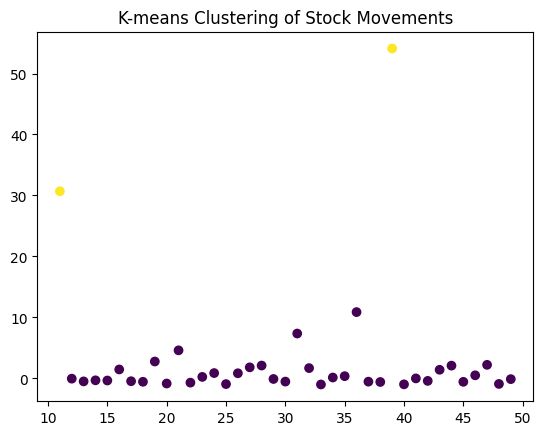

In [292]:
from sklearn.cluster import KMeans

# Compute daily returns
data['Returns'] = data['LTP'].pct_change()

# Drop NaN value (first row)
data = data.dropna()

# Use k-means to cluster stocks based on daily returns
kmeans = KMeans(n_clusters=2)  # Using 2 clusters for illustration
data['Cluster'] = kmeans.fit_predict(data[['Returns']])

# Visualize the clusters
plt.scatter(data.index, data['Returns'], c=data['Cluster'])
plt.title('K-means Clustering of Stock Movements')
plt.show()

* From the above chart as most of the data points in a cluster are hovering around the zero line, it indicates that there are many days when the stock price was relatively stable. This could be seen as a sign of a less risky or less volatile stock during that period.

* There are days when the stock price sees significant movement, either upwards or downwards. This could be due to company-specific news, broader market news, or any other event affecting the stock. Such days are considered riskier as they show the stock's potential for large, unpredictable price changes.

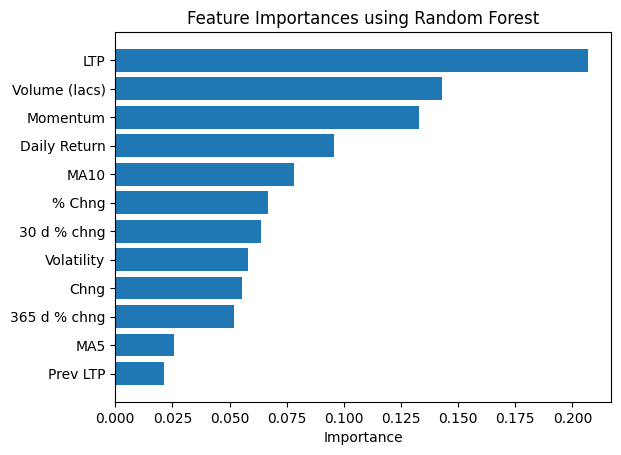

In [293]:
# After training the Random Forest model (as shown above for predicting direction):

importances = clf.feature_importances_
features = data.drop(columns='Direction').columns

# Sort and plot
sorted_idx = importances.argsort()
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()

LTP is the feature with the higheest bar, so its considered more important by the Random Forest for the task of predicting the stock price's direction and has a greater influence on the model's decisions.
Where as, MA5 might not be contributing much to the prediction task and can be removed without sacrificing much predictive power.

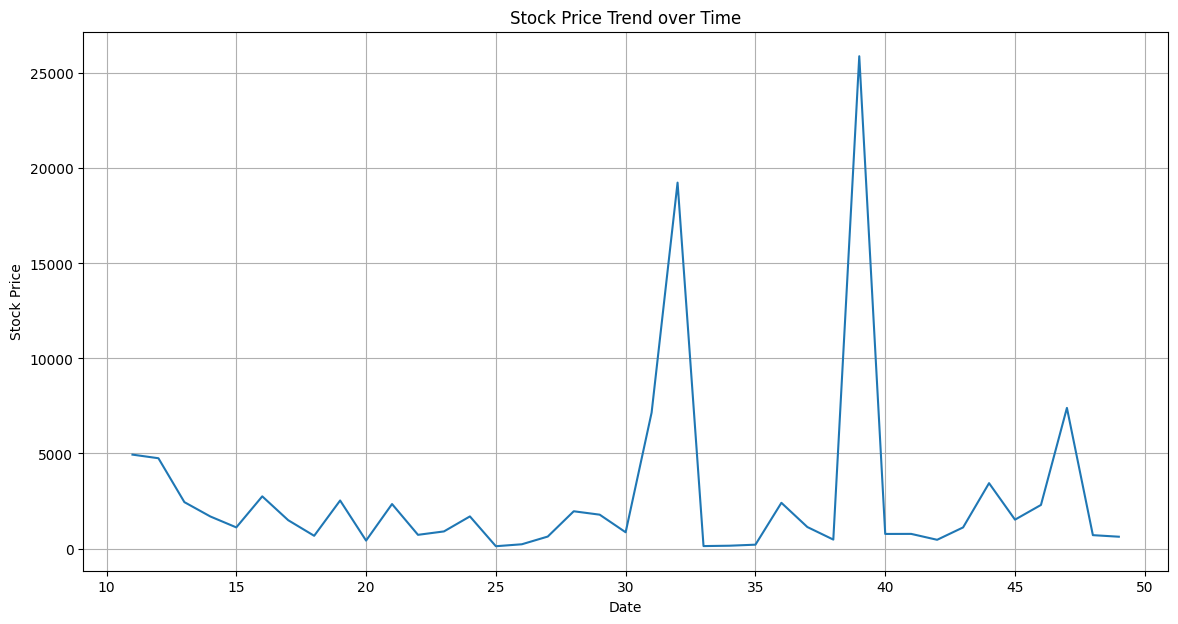

In [294]:
# Trend Analysis
plt.figure(figsize=(14, 7))
plt.plot(data['LTP'])
plt.title('Stock Price Trend over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

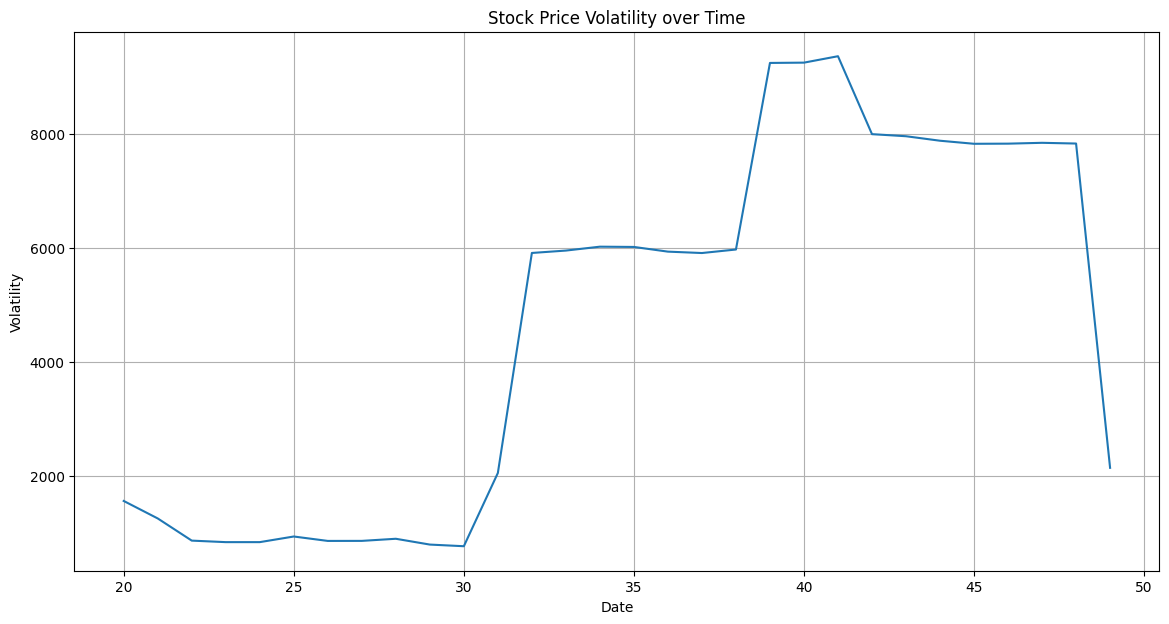

In [295]:
# Volatility Analysis
data['Rolling Std'] = data['LTP'].rolling(window=10).std()

plt.figure(figsize=(14, 7))
plt.plot(data['Rolling Std'])
plt.title('Stock Price Volatility over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

/tmp/ipykernel_32/2761202945.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Daily Returns'].dropna(), bins=100, color='blue')


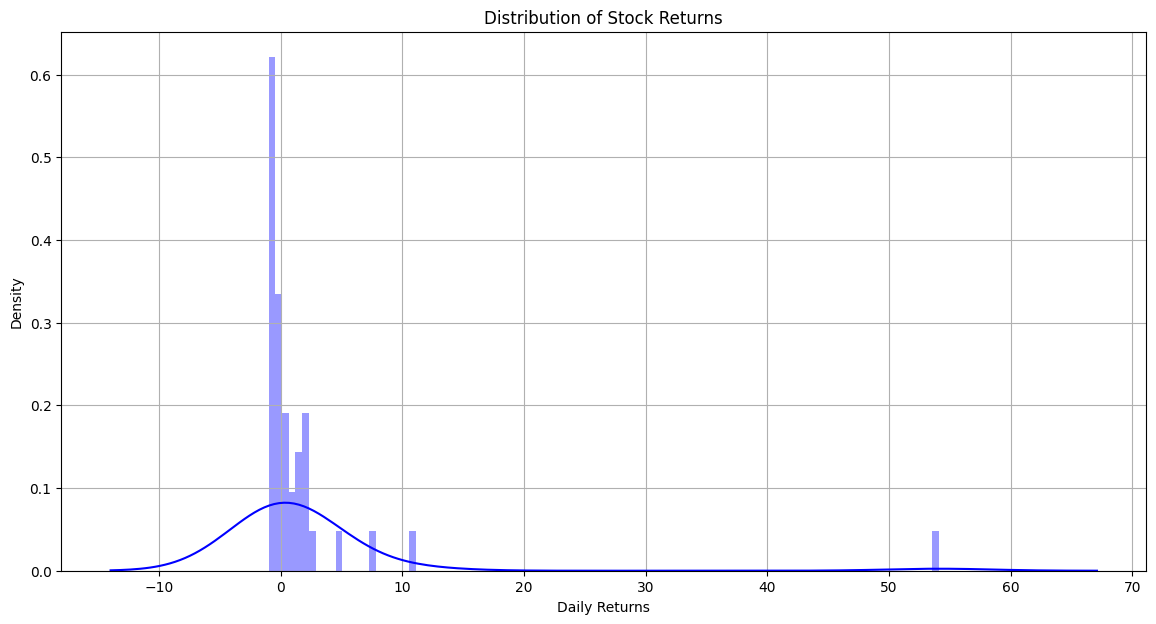

In [296]:
data['Daily Returns'] = data['LTP'].pct_change().dropna()

plt.figure(figsize=(14, 7))
sns.distplot(data['Daily Returns'].dropna(), bins=100, color='blue')
plt.title('Distribution of Stock Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.grid(True)
plt.show()